# Impports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    
from utils.data import load_breast_cancer_kagglehub, standardize_fit_transform
from utils.metrics import silhouette_score, best_k_by_gap, gap_statistic
from KMeans.kmeans_numpy import KMeans


# Load and standardize dataset

In [2]:
X, y, feature_names = load_breast_cancer_kagglehub()
Xs, scaler = standardize_fit_transform(X)


Loaded CSV: C:\Users\Wind\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2\data.csv


# Elbow & Silhouette analysis

In [3]:
ks = list(range(2, 11))  # typical range
seed = 42

inertia_pp, inertia_r = [], []
iters_pp, iters_r = [], []
sil_pp, sil_r = [], []

for k in ks:
    km_pp = KMeans(n_clusters=k, init="kmeans++", max_iter=300, tol=1e-4, random_state=seed)
    labels_pp = km_pp.fit_predict(Xs)

    km_r = KMeans(n_clusters=k, init="random", max_iter=300, tol=1e-4, random_state=seed)
    labels_r = km_r.fit_predict(Xs)

    inertia_pp.append(km_pp.inertia_)
    inertia_r.append(km_r.inertia_)

    iters_pp.append(km_pp.n_iter_)
    iters_r.append(km_r.n_iter_)

    sil_pp.append(silhouette_score(Xs, labels_pp))
    sil_r.append(silhouette_score(Xs, labels_r))

    print(f"k={k}: inertia++={km_pp.inertia_:.2f} iters++={km_pp.n_iter_} sil++={sil_pp[-1]:.4f} | "
          f"inertiaR={km_r.inertia_:.2f} itersR={km_r.n_iter_} silR={sil_r[-1]:.4f}")

k=2: inertia++=11595.68 iters++=8 sil++=0.3447 | inertiaR=11595.53 itersR=7 silR=0.3434
k=3: inertia++=10061.80 iters++=11 sil++=0.3144 | inertiaR=10065.44 itersR=24 silR=0.3151
k=4: inertia++=9335.75 iters++=13 sil++=0.1593 | inertiaR=9334.91 itersR=25 silR=0.1563
k=5: inertia++=8564.47 iters++=24 sil++=0.1675 | inertiaR=8651.05 itersR=20 silR=0.1436
k=6: inertia++=8118.06 iters++=27 sil++=0.1489 | inertiaR=7973.59 itersR=33 silR=0.1661
k=7: inertia++=7689.01 iters++=21 sil++=0.1363 | inertiaR=7902.97 itersR=17 silR=0.1214
k=8: inertia++=7243.92 iters++=19 sil++=0.1331 | inertiaR=7243.87 itersR=31 silR=0.1327
k=9: inertia++=7057.74 iters++=24 sil++=0.1306 | inertiaR=7109.23 itersR=11 silR=0.1169
k=10: inertia++=6669.22 iters++=26 sil++=0.1349 | inertiaR=6928.72 itersR=12 silR=0.1177


# Elbow plot

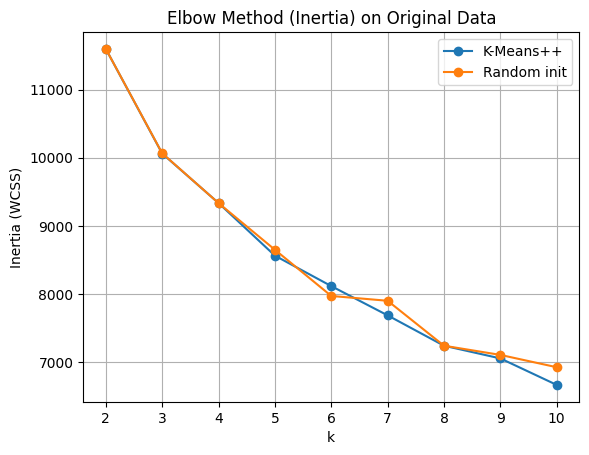

In [4]:
plt.figure()
plt.plot(ks, inertia_pp, marker="o", label="K-Means++")
plt.plot(ks, inertia_r, marker="o", label="Random init")
plt.xlabel("k")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method (Inertia) on Original Data")
plt.grid(True)
plt.legend()
plt.show()

# Silhouette plot

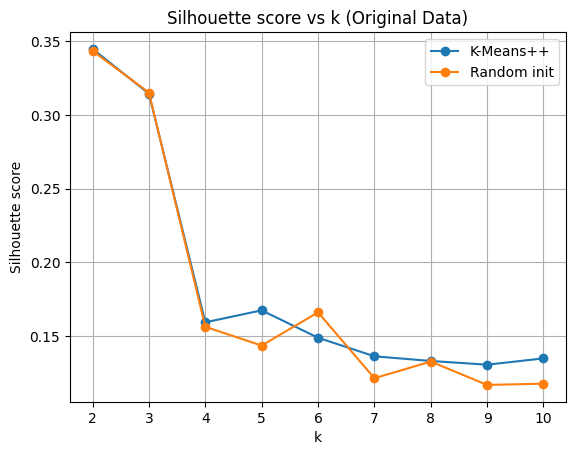

Best k by silhouette (K-Means++): 2
Best k by silhouette (Random): 2


In [5]:
plt.figure()
plt.plot(ks, sil_pp, marker="o", label="K-Means++")
plt.plot(ks, sil_r, marker="o", label="Random init")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score vs k (Original Data)")
plt.grid(True)
plt.legend()
plt.show()

best_k_sil_pp = ks[int(np.argmax(sil_pp))]
best_k_sil_r  = ks[int(np.argmax(sil_r))]
print("Best k by silhouette (K-Means++):", best_k_sil_pp)
print("Best k by silhouette (Random):", best_k_sil_r)

# Gap statistic
Gap Statistic Implementation

In [6]:
def clusterer_factory(init_mode):
    def _factory(k, seed):
        return KMeans(
            n_clusters=k,
            init=init_mode,
            max_iter=300,
            tol=1e-4,
            random_state=seed
        )
    return _factory


# Determining Optimal k Using the Gap Statistic

In [7]:
ks = list(range(2, 11))
B = 10

gaps_pp, sks_pp = [], []
gaps_r, sks_r = [], []

factory_pp = clusterer_factory("kmeans++")
factory_r  = clusterer_factory("random")

for k in ks:
    g, s = gap_statistic(Xs, factory_pp, k, B=B, random_state=42)
    gaps_pp.append(g)
    sks_pp.append(s)

    g, s = gap_statistic(Xs, factory_r, k, B=B, random_state=42)
    gaps_r.append(g)
    sks_r.append(s)

    print(f"k={k}: gap++={gaps_pp[-1]:.4f} sk++={sks_pp[-1]:.4f} | "
          f"gapR={gaps_r[-1]:.4f} skR={sks_r[-1]:.4f}")\
          
best_k_gap_pp = best_k_by_gap(gaps_pp, sks_pp, ks)
best_k_gap_r  = best_k_by_gap(gaps_r, sks_r, ks)
print("Best k by gap rule (++):", best_k_gap_pp)
print("Best k by gap rule (random):", best_k_gap_r)



k=2: gap++=1.9599 sk++=0.0047 | gapR=1.9623 skR=0.0078
k=3: gap++=2.0627 sk++=0.0060 | gapR=2.0658 skR=0.0061
k=4: gap++=2.0996 sk++=0.0055 | gapR=2.1168 skR=0.0069
k=5: gap++=2.1615 sk++=0.0046 | gapR=2.1463 skR=0.0078
k=6: gap++=2.1694 sk++=0.0075 | gapR=2.2025 skR=0.0062
k=7: gap++=2.2540 sk++=0.0086 | gapR=2.2126 skR=0.0080
k=8: gap++=2.2693 sk++=0.0075 | gapR=2.2501 skR=0.0068
k=9: gap++=2.2996 sk++=0.0080 | gapR=2.3056 skR=0.0072
k=10: gap++=2.2994 sk++=0.0076 | gapR=2.3249 skR=0.0081
Best k by gap rule (++): 9
Best k by gap rule (random): 10


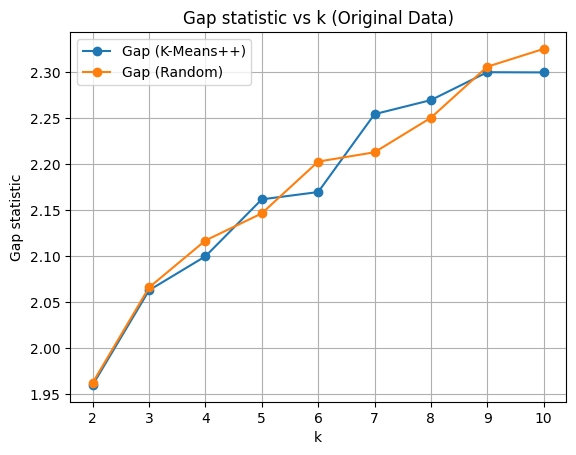

In [8]:
plt.figure()
plt.plot(ks, gaps_pp, marker="o", label="Gap (K-Means++)")
plt.plot(ks, gaps_r, marker="o", label="Gap (Random)")
plt.xlabel("k")
plt.ylabel("Gap statistic")
plt.title("Gap statistic vs k (Original Data)")
plt.grid(True)
plt.legend()
plt.show()

# Convergence speed comparison (iterations)

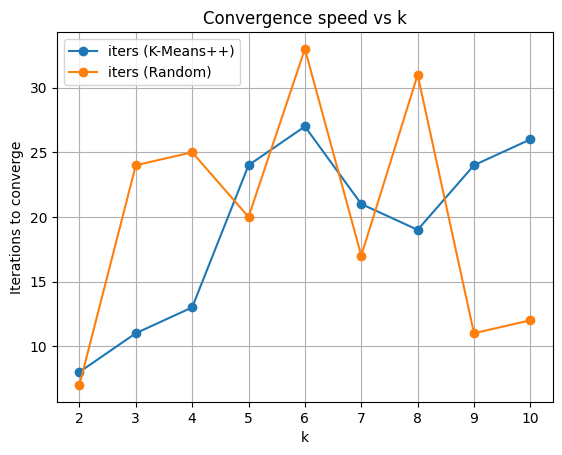

In [9]:
plt.figure()
plt.plot(ks, iters_pp, marker="o", label="iters (K-Means++)")
plt.plot(ks, iters_r, marker="o", label="iters (Random)")
plt.xlabel("k")
plt.ylabel("Iterations to converge")
plt.title("Convergence speed vs k")
plt.grid(True)
plt.legend()
plt.show()